# Lane Finding

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import glob
import cv2

%matplotlib inline

Camera calibration

Correction images (successfully detected corners):


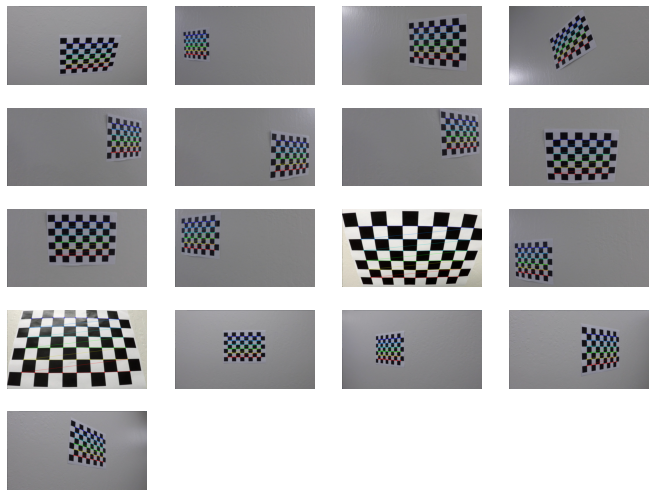


Test images (failed to detect corners):


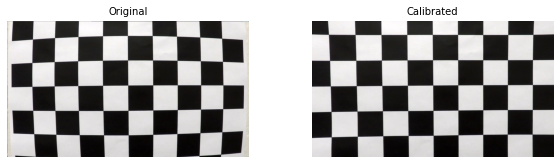

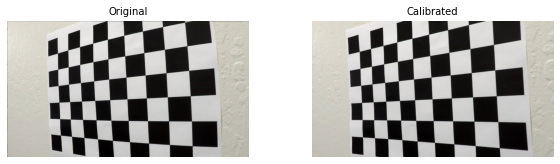

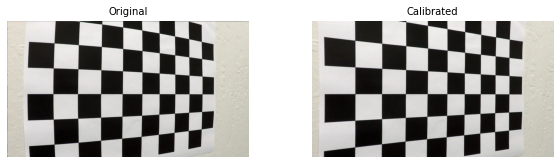

In [30]:
from lanetracker.camera import CameraCalibration

calibrate = CameraCalibration(glob.glob('F:\\detecting-road-features\\data\\camera_cal\\calibration*.jpg'), retain_calibration_images=True)

print('Correction images (successfully detected corners):')
plt.figure(figsize = (11.5, 9))
gridspec.GridSpec(5, 4)
# Step through the list and search for chessboard corners
for i, image in enumerate(calibrate.calibration_images_success):
    plt.subplot2grid((5, 4), (i // 4, i % 4), colspan=1, rowspan=1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

print('\nTest images (failed to detect corners):')
for i, image in enumerate(calibrate.calibration_images_error):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2.5))
    ax1.axis('off')
    ax1.imshow(image)
    ax1.set_title('Original', fontsize=10)
    ax2.axis('off')
    ax2.imshow(calibrate(image))
    ax2.set_title('Calibrated', fontsize=10)

Color & gradient threshold pipeline.

Text(0.5, 1.0, 'Edges')

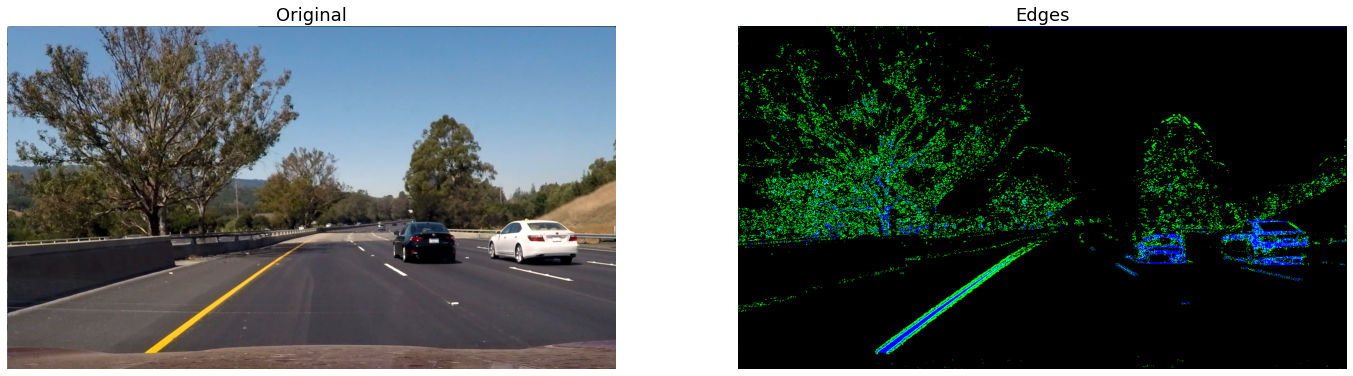

In [6]:
from lanetracker.gradients import get_edges

image = mpimg.imread('F:\\detecting-road-features\\data\\test_images\\test6.jpg')
result = get_edges(image, separate_channels=True)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()
ax1.axis('off')
ax1.imshow(image)
ax1.set_title('Original', fontsize=18)
ax2.axis('off')
ax2.imshow(result)
ax2.set_title('Edges', fontsize=18)

Perspective transform

Text(0.5, 1.0, "Bird's eye view")

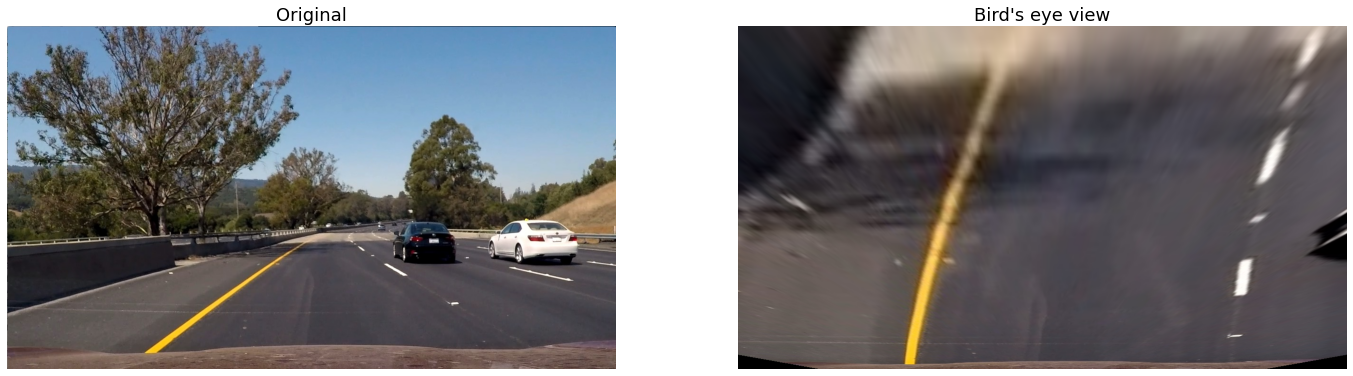

In [8]:
from lanetracker.perspective import flatten_perspective

image = mpimg.imread('F:\\detecting-road-features\\data\\test_images\\test6.jpg')
result, _ = flatten_perspective(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()
ax1.axis('off')
ax1.imshow(image)
ax1.set_title('Original', fontsize=18)
ax2.axis('off')
ax2.imshow(result)
ax2.set_title('Bird\'s eye view', fontsize=18)

Finding the lines

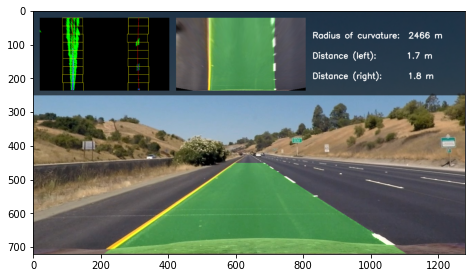

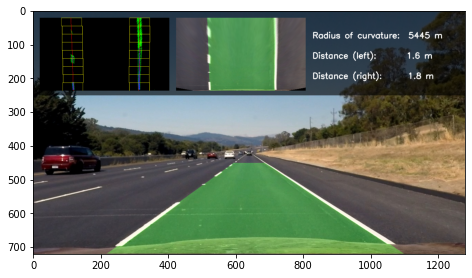

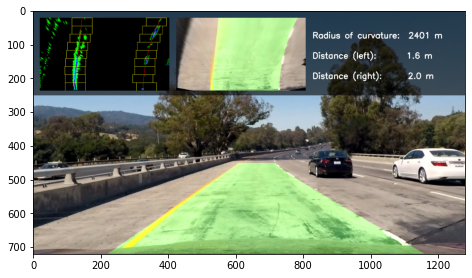

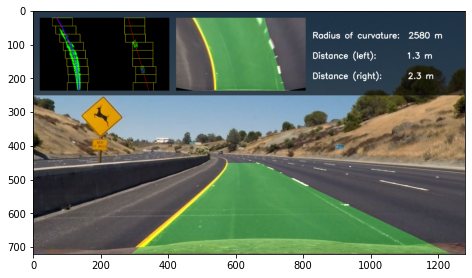

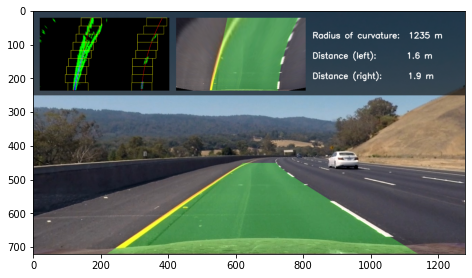

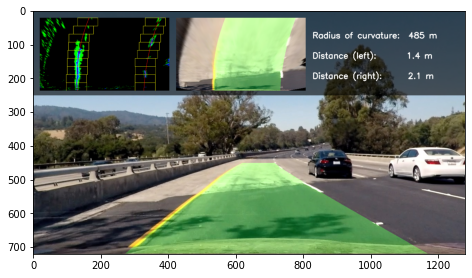

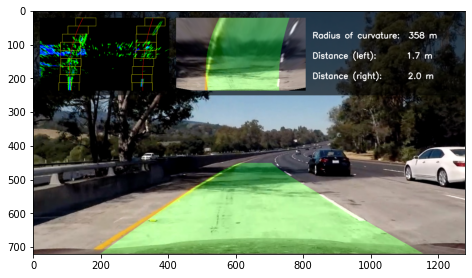

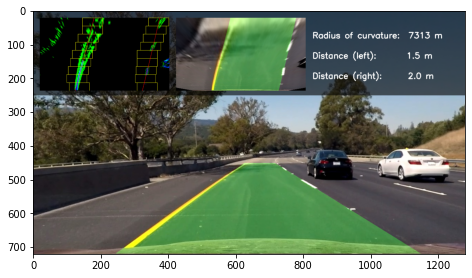

In [20]:
from lanetracker.tracker import LaneTracker

for image_name in glob.glob('F:\\detecting-road-features\\data\\test_images\\*.jpg'):
    calibrated = calibrate(mpimg.imread(image_name))
    lane_tracker = LaneTracker(calibrated)
    overlay_frame = lane_tracker.process(calibrated, draw_lane=True, draw_statistics=True)
    mpimg.imsave(image_name.replace('test_images', 'output_images'), overlay_frame)
    plt.imshow(overlay_frame)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

Applying pipeline to video

In [50]:
from moviepy.editor import VideoFileClip


video_output_name = 'F:\\detecting-road-features\\data\\video\\project_video_annotated.mp4'
video = VideoFileClip("F:\\detecting-road-features\\data\\video\\project_video.mp4")
tracker = LaneTracker(calibrate(video.get_frame(0)), X_scaler, svc)
video_output = video.fl_image(tracker.process)
%time video_output.write_videofile(video_output_name, audio=False)

NameError: name 'X_scaler' is not defined

# Vehicle Tracking

In [48]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

%matplotlib inline

Train a classifier.

In [49]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from vehicletracker.features import FeatureExtractor
from vehicletracker.utilities import print_progress

# Read training data
print('Reading data...')
cars = []
notcars = []
notcars_files = glob.glob('F:\\detecting-road-features\\data\\non-vehicles/*/*.png')
cars_files = glob.glob('F:\\detecting-road-features\\data\\vehicles/*/*.png')
for file in cars_files:
    cars.append(mpimg.imread(file))
    print_progress(len(cars) + len(notcars), len(cars_files) + len(notcars_files))
for file in notcars_files:
    notcars.append(mpimg.imread(file))
    print_progress(len(cars) + len(notcars), len(cars_files) + len(notcars_files))

cars = np.asarray(cars)    
notcars = np.asarray(notcars)    
print('    ...Done')

print('Vehicles images:', cars.shape[0])
print('Non-vehicles images:', notcars.shape[0])

# Extract features
print('Extracting features...')
car_features = []
notcar_features = []
for car in cars:
    car_features.append(FeatureExtractor(car).feature_vector())
    print_progress(len(car_features) + len(notcar_features), len(cars) + len(notcars))
for notcar in notcars:
    notcar_features.append(FeatureExtractor(notcar).feature_vector())
    print_progress(len(car_features) + len(notcar_features), len(cars) + len(notcars))
X = np.vstack((car_features, notcar_features)).astype(np.float64)   
print('    ...Done')

# Perform feature scaling
print('Scaling features...')
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print('    ...Done')

# Train linear SVC classifier
print('Training classifier...')
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)
svc = LinearSVC()
svc.fit(X_train, y_train)
accuracy = round(svc.score(X_test, y_test), 4)
print('    ...Done')
print('Accuracy =', accuracy)

Reading data...
    ...Done
Vehicles images: 0
Non-vehicles images: 0
Extracting features...
    ...Done
Scaling features...


ValueError: Found array with 0 feature(s) (shape=(2, 0)) while a minimum of 1 is required by StandardScaler.

Verify window approach on test images.

In [45]:
from vehicletracker.tracker import VehicleTracker

for image_name in glob.glob('test_images/*.jpg'):
    image = mpimg.imread(image_name)
    tracker = VehicleTracker(X_scaler, svc, image)
    tracker.process(image, draw_detections=True)

    fig = plt.figure(figsize = (16, 8))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

    axis = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    axis.imshow(image)
    axis = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    axis.imshow(tracker.heatmap, cmap='hot')
    plt.show()

Applying pipeline to video

In [46]:
from moviepy.editor import VideoFileClip
from vehicletracker.tracker import VehicleTracker

video_output_name = 'F:\\detecting-road-features\\data\\video\\project_video_annotated_vehicles.mp4'
video = VideoFileClip("F:\\detecting-road-features\\data\\video\\project_video.mp4")
tracker = VehicleTracker(X_scaler, svc, video.get_frame(0))
video_output = video.fl_image(tracker.process)
%time video_output.write_videofile(video_output_name, audio=False)

NameError: name 'X_scaler' is not defined